#**Q. Zero order optimization (Policy Gradient)**

We will now talk about $0^{th}$ order optimization, also known as Policy Gradient in a Reinforcement Learning context. Although this method is primarily used in an RL context we will be adapting this method to do $0^{th}$ order optimization on a Neural Network.

$k^{th}$ order optimization means that in the optimization, we use a $k^{th}$ order derivative ($\frac{δL^k}{δ^kw}$) to do the optimization. So we can see that gradient descent is a first order optimization method, while Newton's method is a second order optimization method.

Polciy gradient is a $0^{th}$ order optimization method - which means that you use no derivative for the optimzation. This is used in contexts in which the loss is a **blackboxed** function, hence propogating a gradient through it is impossible.

Policy gradient at a high level approximates the gradient and then does gradient descent using this approximated gradient.

##**a) A handy derivation**
Prove that $p_{\theta}(x) \nabla_θlog(p_{\theta}(x)) = \nabla_θp_{\theta}(x)$


###**Answer:** 

$p_{\theta}(x) \nabla_θlog(p_{\theta}(x)) = p_{\theta}(x) \frac{\nabla_θp_{\theta}(x)}{p_{\theta}(x)} = \nabla_θp_{\theta}(x)$

##**b) Approximating the derivative**
Let's say we have a neural network $f(x)$ which takes in a $x$ and uses the weights($w$) to output 2 logits <br> ($P = [P(y = 0)$, $P(y = 1)]$). <br> Let $p(x, y)$ be the joint distribution of the input and output data according to **our model**. Hence $p_w(x, y) = p(x)p_w(y|x)$, where p(x) is the ground distribution of x, while $p_w(y|x) = f(x)[y]$ is what our model predicts. 
<br><br>

Similarly we have a **blackboxed** loss function $L(x, f(x))$ which outputs a loss. <br>
For example if i wanted to learn to classify y = 1 if x > 5 and y = 0 otherwise, L(4, (0.1, 0.9)) would be small while L(4, (0.9, 0.1)) would be very high. As we already discussed, since this loss is blackboxed we can't take the derivative through it.
<br><br>
We want to optimize the following objective function <br>
$w^* = argmin_wJ(w)$ <br> where $J(w) = E_{(x, f(x)) \sim p_w(x, y)}[L(x, f(x))]$. 
<br>
To do this optimization we want to approximate $\nabla_{w} J(w)$ so that we could use an optimization method like gradient descent to find $w^*$ 
<br><br>
**Prove that $\nabla_{w} J(w)$ can be approximated as $\frac{1}{N}∑_{i=1}^{i=N}(\nabla_wlog(p_w(y_i|x_i))L(x_i, f(x_i))$**
<br><br>
**HINTS:**
<ol>
<li>Try creating a $\tau = (x, f(x))$</li>
<li>$E[X] = \int_xxP(X=x)dx$ </li>
<li>Use the result from part a which was $p_{\theta}(x) \nabla_θlog(p_{\theta}(x)) = \nabla_θp_{\theta}(x)$</li>
<li>$p_w(x, y) = p(x)p_w(y|x)$</li>
</ol>

###**Answer:**
$w^* = argmin_wE_{(x, f(x)) \sim p_w(x, y)}[L(x, f(x))]$. 
<br><br><br>

We call $J(w) = E_{(x, f(x)) \sim p_w(x, y)}[L(x, f(x))]$ and $\tau = (x, f(x))$
<br><br><br>

$J(w) = E_{\tau \sim p_w(\tau)}[L(\tau)] = ∫_{\tau}p_w(\tau)L(\tau)d\tau$
<br><br><br>


Hence $\nabla_{w} J(w) = ∫_\tau(\nabla_wp_w(\tau))L(\tau)d\tau$ <br><br>
&emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &nbsp;
$= ∫_\tau(\nabla_wlog(p_w(\tau)))p_w(\tau)L(\tau)d\tau$ &emsp; &emsp; &emsp; (Using part a)
<br><br> &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &nbsp;
 $ = E_{\tau \sim p_w(\tau)}[(\nabla_wlog(p_w(\tau))L(\tau)]$
<br><br><br>
We know that $\nabla_wlog(p_w(\tau)) = \nabla_w[log(p(x)) + log(p_w(y|x))]$ <br><br>Since $p(x)$ does not depend on $w$ we can simplify this to $\nabla_wlog(p_w(y|x))$
<br><br><br>
Hence $\nabla_{w} J(w) = E_{\tau \sim p_w(\tau)}[(\nabla_wlog(p_w(\tau))L(\tau)] = E_{\tau \sim p_w(\tau)}[(\nabla_wlog(p_w(y|x))L(x, f(x))]$ <br><br> which can be approximated as $\frac{1}{N}∑_{i=1}^{i=N}(\nabla_wlog(p_w(y_i|x_i))L(x_i, f(x_i))$


In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch as torch
import torch.nn.functional as F
from torch import nn

In [2]:
# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda


### Data Generation

In this question, each datapoint is a 8 dimensional vector assigned to one of the four labels depending on their distance to two points $\mathbf{1}$ and $-\mathbf{1}$.

In [3]:
def generate_data(num_samples, input_dim):
    @torch.no_grad()
    def true_y(x):
        dp = ((x - 1) ** 2).sum(dim=-1)
        dn = ((x + 1) ** 2).sum(dim=-1)
        zp = dp <= input_dim * 2.5
        zn = dn <= input_dim * 2.5

        return torch.stack([
            zp & zn,
            zp & ~zn,
            ~zp & zn,
            ~zp & ~zn
        ], dim=1).long().argmax(dim=-1)
    
    x = torch.rand((num_samples, input_dim)) * 4.4 - 2.2
    y = true_y(x)
    return x, y, true_y

Here is a visualization when the input dimension is 2:

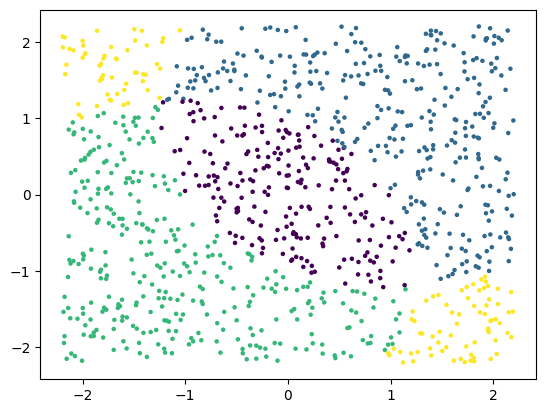

In [4]:
x, y, true_y = generate_data(1000, 2)
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=y.numpy(), s=5)

Let's generate data for input dimension of 8.

In [5]:
torch.manual_seed(73)
np.random.seed(73)
x, y, true_y = generate_data(1000, 8)
x_test, y_test, _ = generate_data(1000, 8)
x, y = x.to(device), y.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

Here is the definition of our model:

In [6]:
def get_model(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    return nn.Sequential(
        OrderedDict(
            [  # randomly initialized NN
                ('fc1', nn.Linear(8, 32)),
                ('relu1', nn.ReLU()),
                ('output', nn.Linear(32, 4))]
        )
    ).to(device)

Here is the definition of our metric: accuracy.

In [7]:
@torch.no_grad()
def accuracy(model, x, y):
    pred = torch.argmax(model(x), dim=1)
    correct = torch.sum(pred == y).item()
    acc = (correct / len(y)) * 100
    return acc

### Supervised Learning

In [8]:
lr = 0.002
num_iters = 3000
model = get_model(73)
optimizer = torch.optim.Adam(model.parameters(), lr)
train_accs = []
train_accs.append(accuracy(model, x, y))
valid_accs = []
valid_accs.append(accuracy(model, x_test, y_test))
for epoch in range(num_iters):
    logits = model(x)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(logits, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_accs.append(accuracy(model, x, y))
    valid_accs.append(accuracy(model, x_test, y_test))

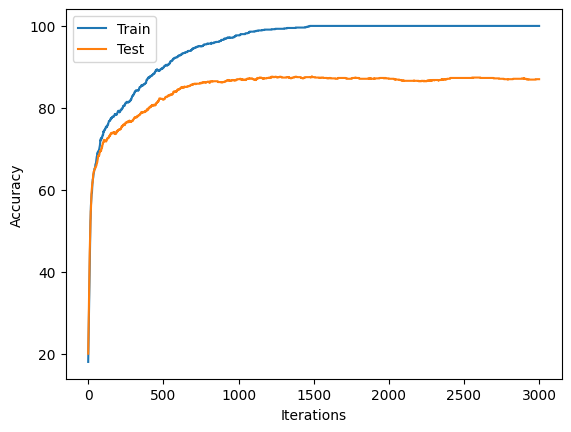

Final test accuracy: 87.0


In [9]:
plt.plot([i for i in range(len(train_accs))], train_accs, label="Train")
plt.plot([i for i in range(len(valid_accs))], valid_accs, label="Test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print("Final test accuracy:", valid_accs[-1])

### Policy Gradient

In [10]:
# Reward Oracle Function (Black-boxed)
# This function calculates the reward, returning 3 for correct predictions and -1 for incorrect ones.
# Usage guidelines:
# - Call this function only; do not rely on its internal implementation details.
# - Gradients are not calculated within this function due to the `@torch.no_grad()` decorator.
@torch.no_grad()
def reward_oracle(x, pred):
    return torch.where(true_y(x) == pred, 3, -1)

**Implement Policy Gradient Algorithm:** Based on the formulas derived in part (b), complete the policy gradient implementation. For this task, we will use the Adam optimizer and process the full dataset in a single batch. The reward oracle has been invoked for you in the provided code. Remember, do not use the true labels directly in your implementation.

In [11]:
lr = 0.002
num_iters = 3000
model = get_model(73)
optimizer = torch.optim.Adam(model.parameters(), lr)
train_accs = []
train_accs.append(accuracy(model, x, y))
valid_accs = []
valid_accs.append(accuracy(model, x_test, y_test))
for epoch in range(num_iters):
    logits = model(x)
    logprob = F.log_softmax(logits, dim=-1)

    predicted = logits.detach().argmax(dim=-1)
    reward = reward_oracle(x, predicted)

    ############################################################################
    # TODO: Calculate the loss function of policy gradient
    ############################################################################
    logprob_on_predicted = torch.gather(
        logprob,
        dim=1,
        index=predicted.unsqueeze(-1)
    ).squeeze(-1)

    loss = -(logprob_on_predicted * reward).mean()
    ############################################################################

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_accs.append(accuracy(model, x, y))
    valid_accs.append(accuracy(model, x_test, y_test))

#### Question

**Include the screenshot of the accuracy plot** in your written assignment submission. With a correct implementation, you should observe an accuracy of approximately 90% after the final iteration.

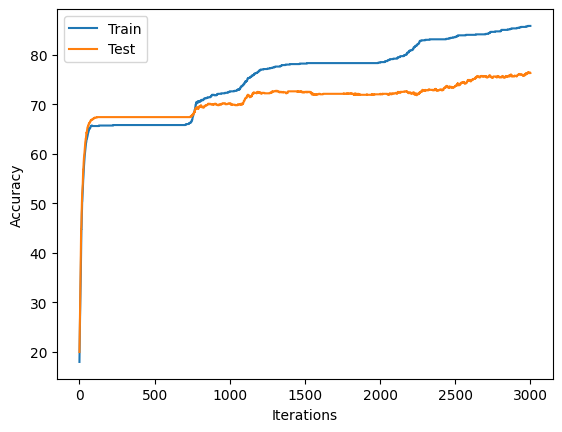

Final test accuracy: 76.3


In [12]:
plt.plot([i for i in range(len(train_accs))], train_accs, label="Train")
plt.plot([i for i in range(len(valid_accs))], valid_accs, label="Test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print("Final test accuracy:", valid_accs[-1])

#### Question

**Compare the policy gradient and supervised learning approaches for this classification task, focusing on their convergence speed, stability, and final performance. Explain any observed differences.** Include your response to this question in your written assignment submission.